# Statement problem
This project is motivated by the critical need to monitor public sentiment surrounding vaccinations, given the ongoing efforts to combat the COVID-19 pandemic.We delve into the analysis of social media(Twitter) sentiment towards vaccines, particularly focusing on COVID-19 vaccines.

## Data collection
This data was downloaded from Kaggle.

In [1]:
!pip install transformers 

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [3]:
data = pd.read_csv('vaccination_tweets.csv')
data.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [4]:
data.shape

(11020, 16)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11020 entries, 0 to 11019
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                11020 non-null  int64 
 1   user_name         11020 non-null  object
 2   user_location     8750 non-null   object
 3   user_description  10341 non-null  object
 4   user_created      11020 non-null  object
 5   user_followers    11020 non-null  int64 
 6   user_friends      11020 non-null  int64 
 7   user_favourites   11020 non-null  int64 
 8   user_verified     11020 non-null  bool  
 9   date              11020 non-null  object
 10  text              11020 non-null  object
 11  hashtags          8438 non-null   object
 12  source            11019 non-null  object
 13  retweets          11020 non-null  int64 
 14  favorites         11020 non-null  int64 
 15  is_retweet        11020 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 1.2+ MB


In [6]:
data.isnull().sum()

id                     0
user_name              0
user_location       2270
user_description     679
user_created           0
user_followers         0
user_friends           0
user_favourites        0
user_verified          0
date                   0
text                   0
hashtags            2582
source                 1
retweets               0
favorites              0
is_retweet             0
dtype: int64

Since our data contains 11020 entities dropping the missing values wouldn't have a large impact on our model building.

In [7]:
data = data.dropna(axis=1)

In [8]:
data.duplicated().sum()

0

We will mainly focus on the text column as it is the most relevant to our case.

In [9]:
content = data['text']
content

0        Same folks said daikon paste could treat a cyt...
1        While the world has been on the wrong side of ...
2        #coronavirus #SputnikV #AstraZeneca #PfizerBio...
3        Facts are immutable, Senator, even when you're...
4        Explain to me again why we need a vaccine @Bor...
                               ...                        
11015    The number of Covid-19 cases today, 17 Novembe...
11016                        First dose ✅\n#PfizerBioNTech
11017    The number of Covid-19 cases today, 16 Novembe...
11018    #PfizerBioNTech has developed new pill #Paxlov...
11019    The number of Covid-19 cases today, 15 Novembe...
Name: text, Length: 11020, dtype: object

In [10]:
content = pd.DataFrame(content, columns=['text'])

## Text cleaning 

In [11]:
import nltk
import string
import re
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
stopword = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()
from textblob import TextBlob
from wordcloud import WordCloud
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image


In [12]:
# Removing Digits
content['text'] = content['text'].apply(lambda d: re.sub(r'\d','',d))

In [13]:
#removes all commas
content['text'] = content['text'].apply(lambda v: re.sub(',', '', v))

In [14]:
#a function to remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile(
        "[" 
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F700-\U0001F77F"  # Alchemical Symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"  # Enclosed Characters
        "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)

content['text'] = content['text'].apply(remove_emoji)
content


,text
0,Same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,Facts are immutable Senator even when you're n...
4,Explain to me again why we need a vaccine @Bor...
...,...
11015,The number of Covid- cases today November .\n...
11016,First dose \n#PfizerBioNTech
11017,The number of Covid- cases today November .\n...
11018,#PfizerBioNTech has developed new pill #Paxlov...


In [15]:
#remove HTML tags
def remove_html(text):
    html_pattern = re.compile(r'<.*?>')
    return html_pattern.sub(r'', text)

content['text'] = content['text'].apply(remove_html)
content


,text
0,Same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,Facts are immutable Senator even when you're n...
4,Explain to me again why we need a vaccine @Bor...
...,...
11015,The number of Covid- cases today November .\n...
11016,First dose \n#PfizerBioNTech
11017,The number of Covid- cases today November .\n...
11018,#PfizerBioNTech has developed new pill #Paxlov...


In [16]:
# remove URLs
def remove_URL(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

content['text'] = content['text'].apply(remove_URL)
content


,text
0,Same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,Facts are immutable Senator even when you're n...
4,Explain to me again why we need a vaccine @Bor...
...,...
11015,The number of Covid- cases today November .\n...
11016,First dose \n#PfizerBioNTech
11017,The number of Covid- cases today November .\n...
11018,#PfizerBioNTech has developed new pill #Paxlov...


#### Data Preparation, Tokenization, Stopwords Removal and Stemming

#### lower casing the text 

In [17]:
content['text'] = content['text'].str.lower()
content

,text
0,same folks said daikon paste could treat a cyt...
1,while the world has been on the wrong side of ...
2,#coronavirus #sputnikv #astrazeneca #pfizerbio...
3,facts are immutable senator even when you're n...
4,explain to me again why we need a vaccine @bor...
...,...
11015,the number of covid- cases today november .\n...
11016,first dose \n#pfizerbiontech
11017,the number of covid- cases today november .\n...
11018,#pfizerbiontech has developed new pill #paxlov...


In [18]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [19]:
#removes all punctuation characters from each  review.
content['text'] = content['text'].apply(lambda doc:"".join([x for x in doc if x not in punctuation]))

In [20]:
#removes all commas from each review.
content['text'] = content['text'].apply(lambda v: re.sub(',', '', v))

In [21]:
content.sample(10)

,text
9047,ukraine changes pfizerbiontech storage require...
2332,managed to get mum her secondvaccination win n...
2764,oxfordastrazeneca pfizerbiontech what happens ...
2037,my friend who has come out of retirement to ad...
7375,breaking the moderna and pfizerbiontech vaccin...
1603,an irish boy writes to pfizer requesting a vac...
10076,the number of covid cases today august \n\nre...
267,tedcruz stoolpresidente you were hatched in ca...
10082,my son and i got our first dose of the pfizerb...
3089,friends give friends mrna our own dnpkelly va...


In [22]:
# Remove rows where the list is empty
content = content[content['text'].apply(lambda x: len(x) > 0)]

# Check the result
print(content.head(10))


                                                text
0  same folks said daikon paste could treat a cyt...
1  while the world has been on the wrong side of ...
2  coronavirus sputnikv astrazeneca pfizerbiontec...
3  facts are immutable senator even when youre no...
4  explain to me again why we need a vaccine bori...
5  does anyone have any useful adviceguidance for...
6  it is a bit sad to claim the fame for success ...
7  there have not been many bright days in  but h...
8  covid vaccine you getting it\n\n covidvaccine ...
9  covidvaccine \n\nstates will start getting cov...


#### Removing Stop words

In [23]:
stop_words = set(stopwords.words("english"))
print(stop_words)

{'doesn', 'been', 'further', 'won', 'ma', 'an', 'through', 'no', 'hers', "mightn't", 'themselves', 'out', 'most', 't', 'the', 'why', 'only', "hadn't", 'both', "you'd", 'he', 'this', 'am', 'a', 'than', 'in', 'just', 'do', 'we', 'our', 'very', "should've", "you're", "doesn't", 'above', 'from', 'be', 'ourselves', 'll', 'does', 'until', 'yourselves', 'having', 'which', "shan't", 'each', 'into', "haven't", 'with', 'some', 'is', 'myself', 'by', 'about', 'same', 'herself', 'have', 'here', "shouldn't", 'had', 'once', "don't", "that'll", 'under', 'she', 'between', 'on', 'aren', 'ours', "didn't", 'did', 'because', 'was', 'against', 'off', 'after', 'its', "hasn't", 'now', 'nor', 'mightn', 'will', 'are', 'shouldn', 'theirs', 're', 'and', 'needn', 'or', 'while', "couldn't", 'her', 'again', 'of', 'when', 'can', "aren't", 'him', 'before', 'them', 'they', 'to', 'then', 'more', 'own', 'isn', 'few', "weren't", 'at', 'below', 'didn', 'couldn', 'm', 'too', 'other', 'for', 'not', 'if', 'over', 'doing', 'bu

In [24]:
#This line of code removes all stop words.
content['text'] = content['text'].apply(lambda y: " ".join([j for j in y.split() if j not in stop_words]))
content.sample(10)

,text
931,switzerland approved use pfizerbiontech vaccin...
4700,fantastic sense relief morale boost receive se...
4534,skyriakideseu astrazeneca eucommission failed ...
2967,happy sunday guys interview interesting infect...
3075,privileged receive dose pfizerbiontech vaccine...
9938,know anyone whos hesitant get jabbed tell read...
6371,dhscgovuk mostly mild reactions covid vaccine ...
6329,newest topic conversation amongst recently jab...
1838,pfizer biontech first get approval american re...
7356,pfizerbiontech vaccine evidence protects young...


#### Tokenization


In [25]:
content['text'] = content['text'].apply(word_tokenize)
content.sample(10)

,text
2174,"[got, first, dose, modernatx, vaccine, incredi..."
744,"[downingstreet, well, done, people, volunteere..."
8000,"[ecstatic, first, dose, recipient, annnnd, bac..."
4025,"[news, cowansview, south, africa, started, thi..."
9459,"[remarkable, number, anonymous, accounts, cont..."
9565,"[happy, faces, part, join, us, bantry, new, pr..."
10156,"[day, pfizerbiontech, covid, vaccine, covidarm..."
3297,"[st, dose, big, thanks, nhskentchft, whole, pr..."
8312,"[uk, england, covid, two, doses, oxfordastraze..."
2534,"[eu, plans, purchase, million, covid, vaccines..."


#### Part of speech tags

In [26]:
content['text'] = content['text'].apply(nltk.tag.pos_tag)
content.head()

,text
0,"[(folks, NNS), (said, VBD), (daikon, JJ), (pas..."
1,"[(world, NN), (wrong, JJ), (side, NN), (histor..."
2,"[(coronavirus, NN), (sputnikv, NN), (astrazene..."
3,"[(facts, NNS), (immutable, JJ), (senator, NN),..."
4,"[(explain, RB), (need, JJ), (vaccine, NN), (bo..."


##### Convert part of speech to wordnet format

In [27]:
# Converting part of speeches to wordnet format.

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

content['text'] = content['text'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

content.head()    

,text
0,"[(folks, n), (said, v), (daikon, a), (paste, n..."
1,"[(world, n), (wrong, a), (side, n), (history, ..."
2,"[(coronavirus, n), (sputnikv, n), (astrazeneca..."
3,"[(facts, n), (immutable, a), (senator, n), (ev..."
4,"[(explain, r), (need, a), (vaccine, n), (boris..."


In [28]:
# Applying word lemmatizer(converts the word to a meaningful base form. For example, "running" becomes "run", "better" becomes "good" if part-of-speech is considered.)


wnl = WordNetLemmatizer()

content['text'] = content['text'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

content.head()

,text
0,"[folk, say, daikon, paste, could, treat, cytok..."
1,"[world, wrong, side, history, year, hopefully,..."
2,"[coronavirus, sputnikv, astrazeneca, pfizerbio..."
3,"[fact, immutable, senator, even, youre, ethica..."
4,"[explain, need, vaccine, borisjohnson, matthan..."


# Data Visualization


#### Most common unigrams

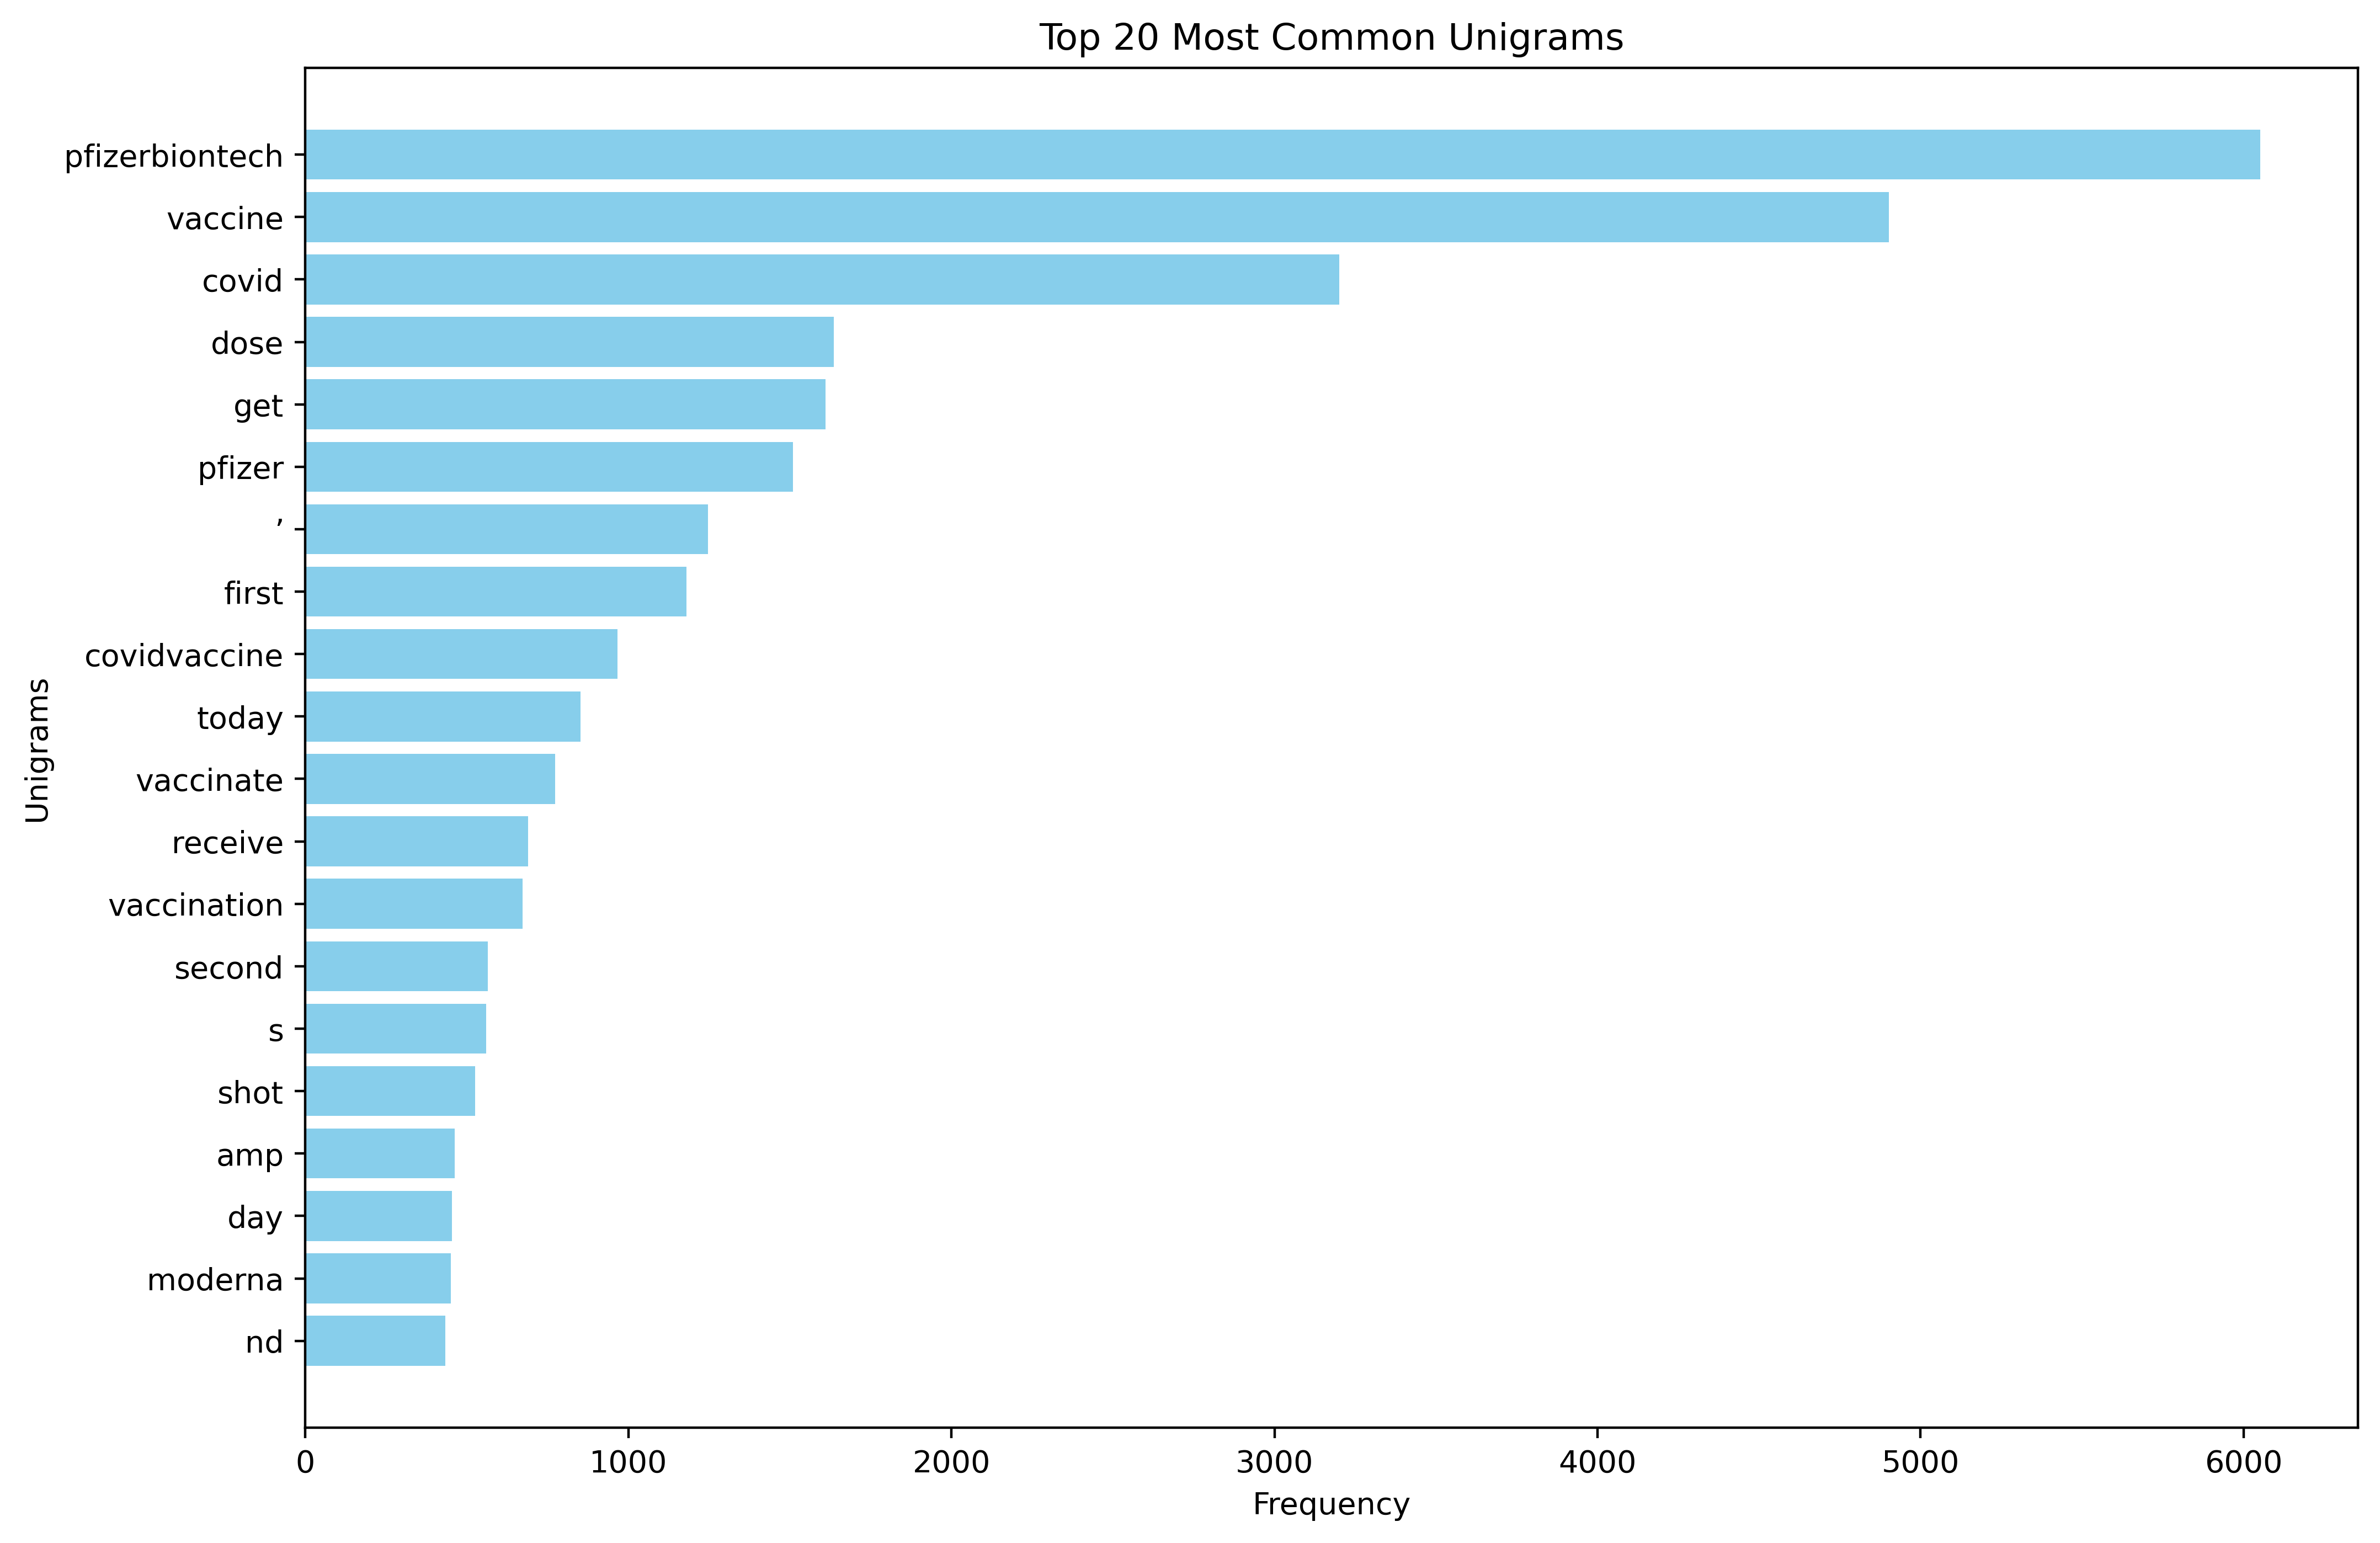

In [29]:
from collections import Counter
# Flatten the list of words in the entire dataset
all_words = [word for tokens in content['text'] for word in tokens]

# Count the frequency of each word
word_freq = Counter(all_words)

# Get the 20 most common unigrams
common_words = word_freq.most_common(20)

# Split the words and their counts for plotting
words, counts = zip(*common_words)

# Plotting the most common unigrams 
plt.figure(figsize=(12, 8), dpi=400)
plt.barh(words, counts, color='skyblue')
plt.gca().invert_yaxis() 
plt.xlabel('Frequency')
plt.ylabel('Unigrams')
plt.title('Top 20 Most Common Unigrams')
plt.show()



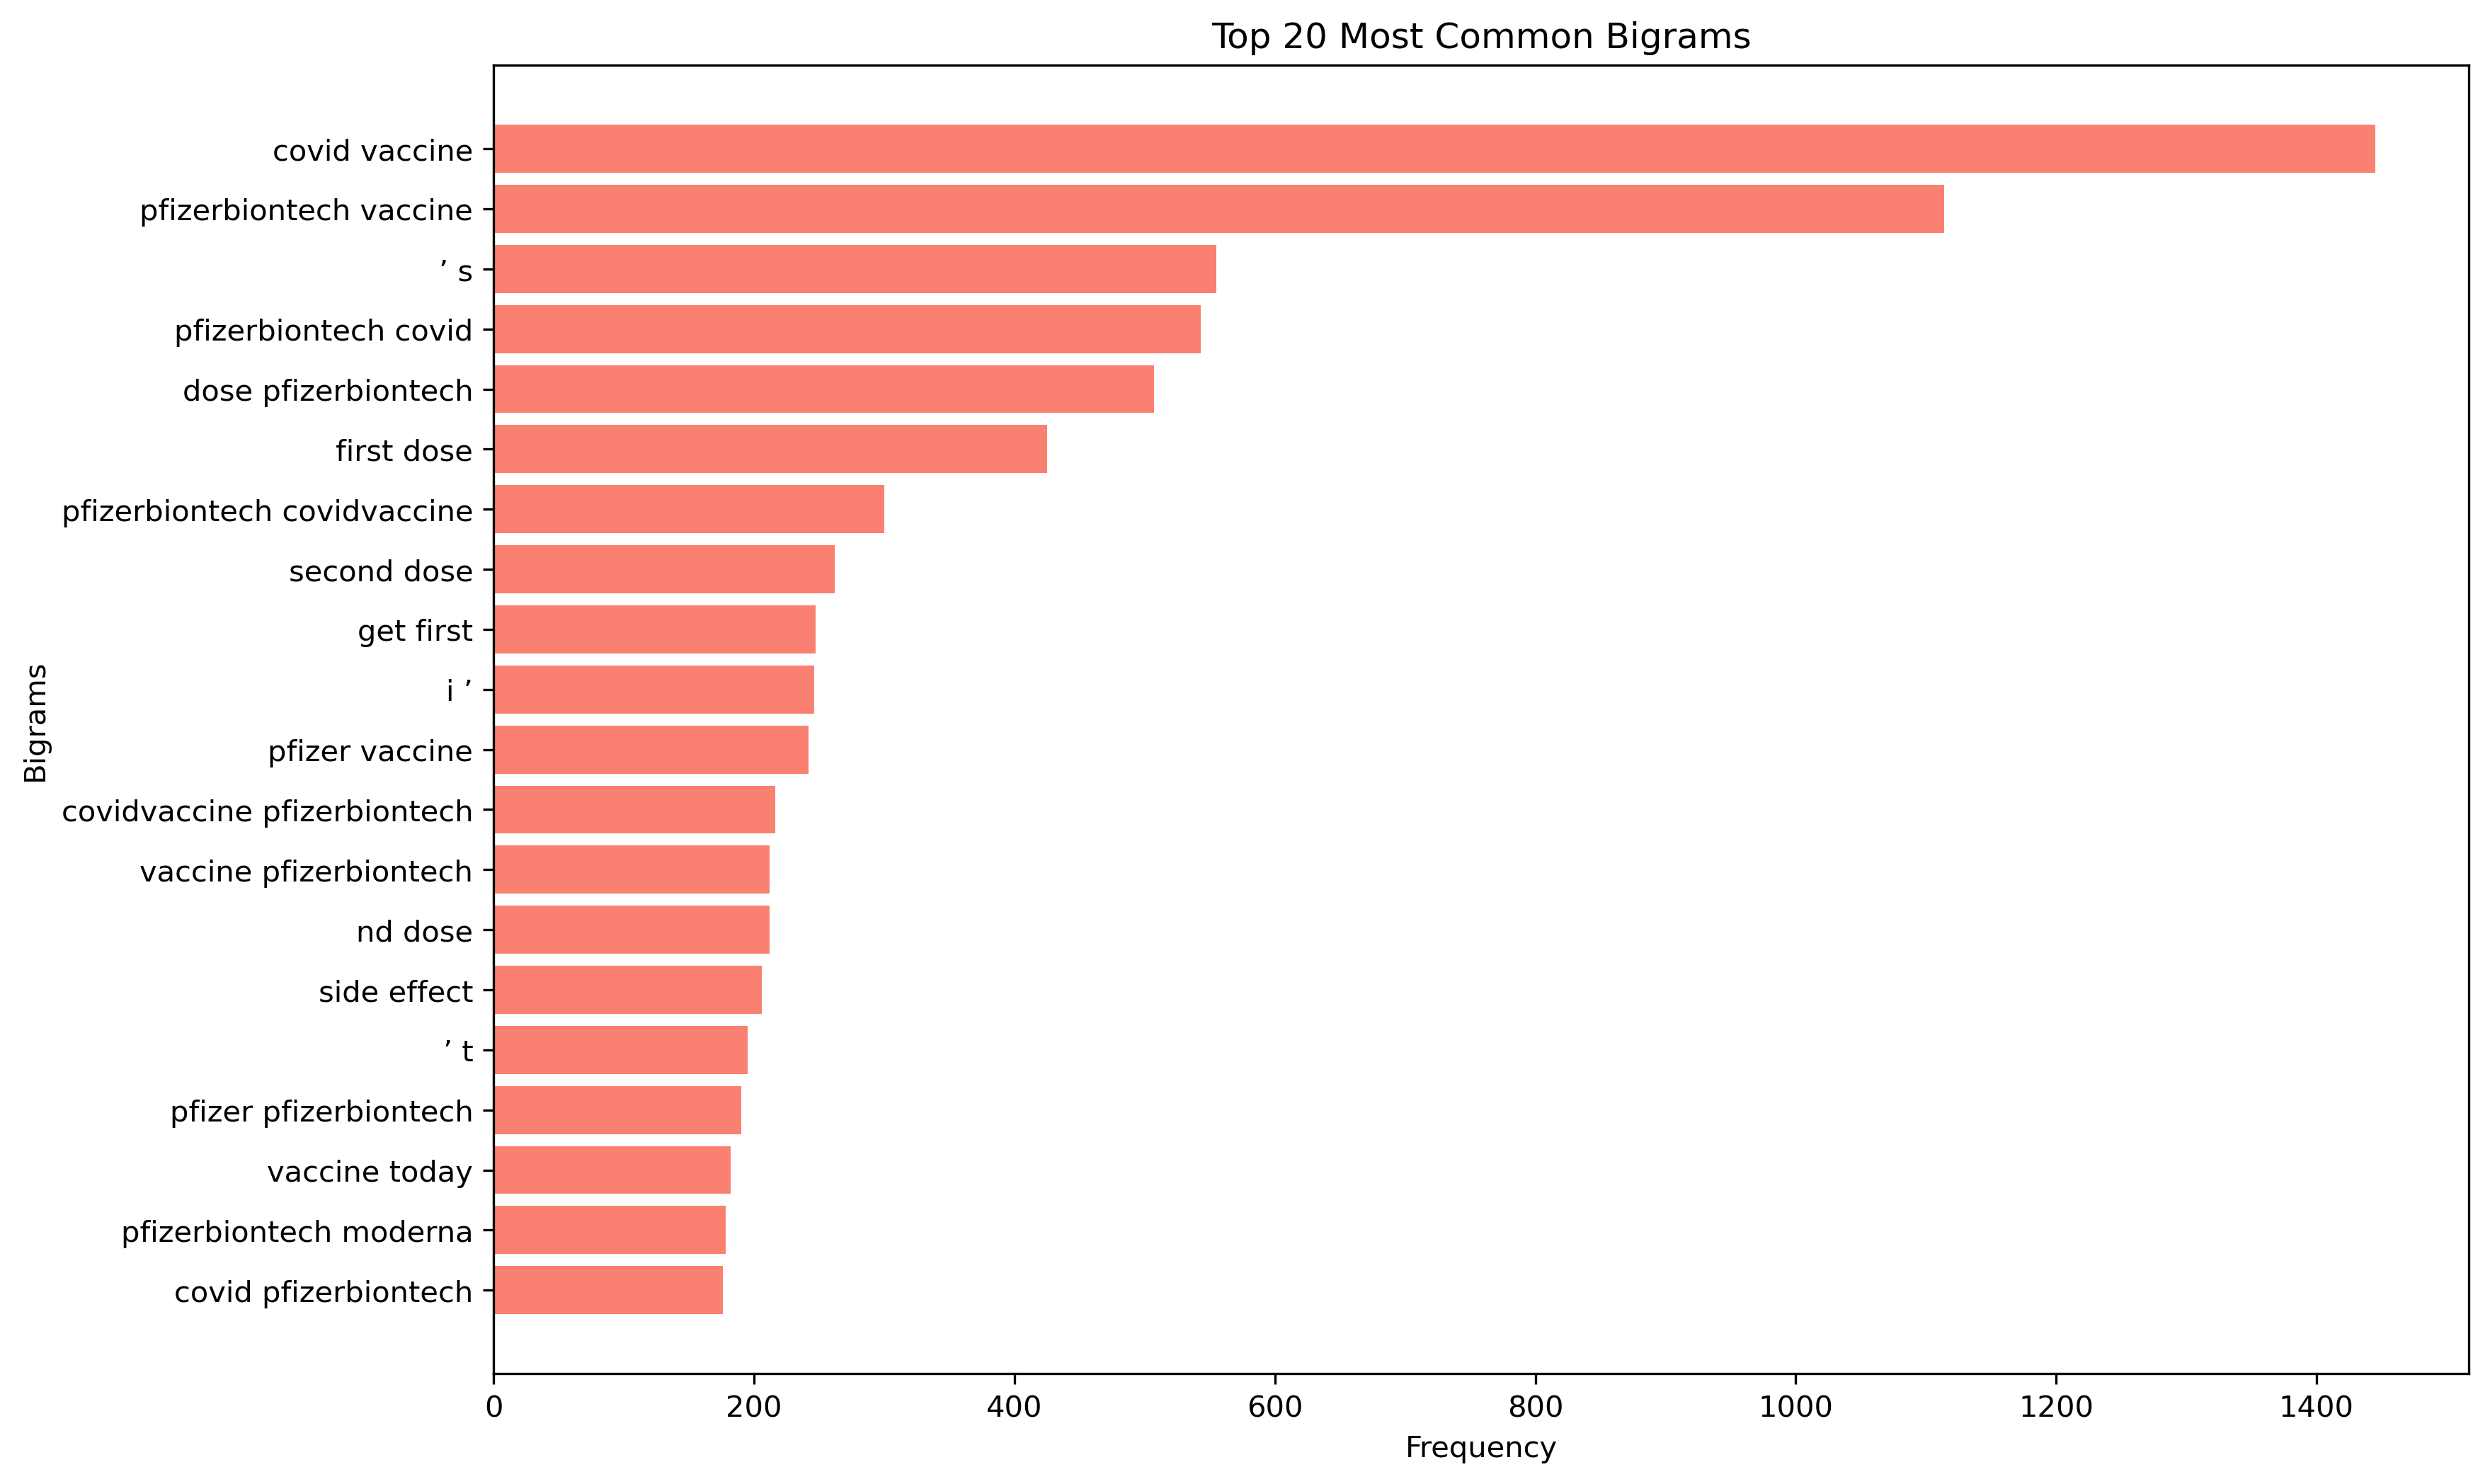

In [30]:
from collections import Counter
from nltk import bigrams

# Generate bigrams from the tokenized text
all_bigrams = [bigram for tokens in content['text'] for bigram in bigrams(tokens)]

# Count the frequency of each bigram
bigram_freq = Counter(all_bigrams)

# Get the 20 most common bigrams
common_bigrams = bigram_freq.most_common(20)

# Split the bigrams and their counts for plotting
bigrams_labels, counts = zip(*common_bigrams)
bigrams_labels = [' '.join(bigram) for bigram in bigrams_labels]  # Join bigrams into readable format

# Plotting the most common bigrams with increased DPI
plt.figure(figsize=(12, 8), dpi=300)
plt.barh(bigrams_labels, counts, color='salmon')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most common at the top
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.title('Top 20 Most Common Bigrams')
plt.show()


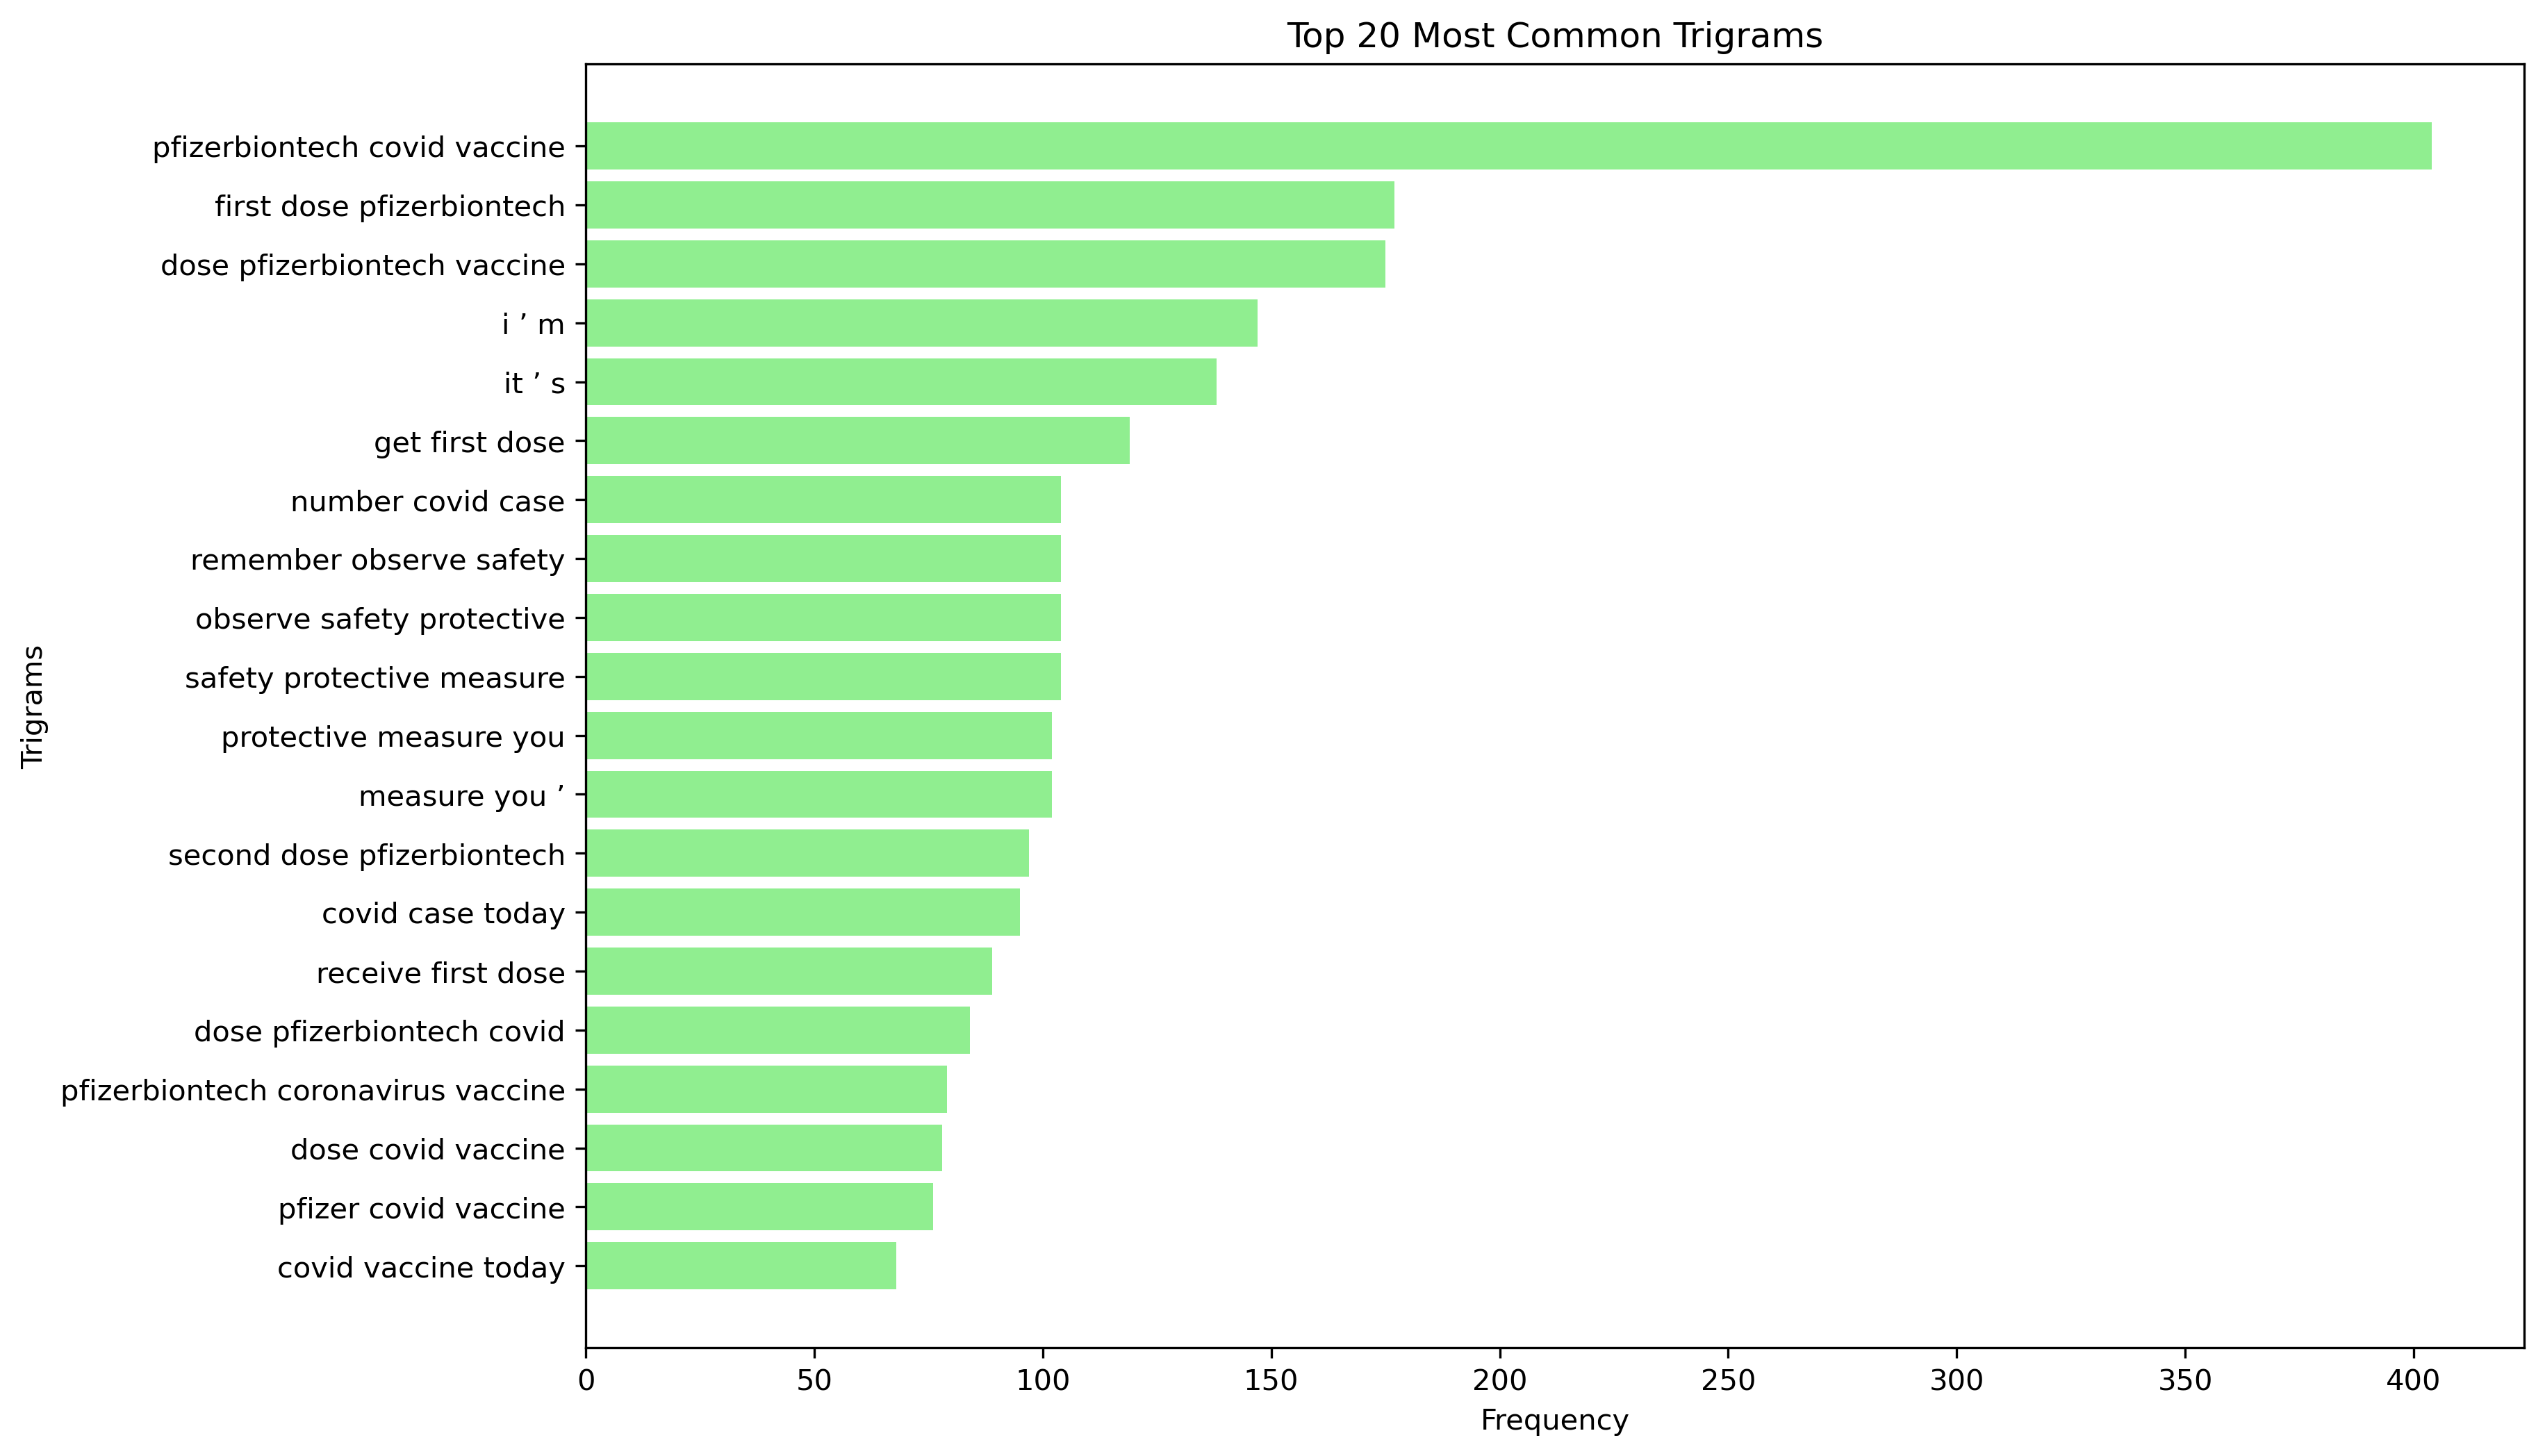

In [31]:
import matplotlib.pyplot as plt
from collections import Counter
from nltk import trigrams
import pandas as pd

# Assuming content['text'] contains lists of tokenized and filtered words

# Generate trigrams from the tokenized text
all_trigrams = [trigram for tokens in content['text'] for trigram in trigrams(tokens)]

# Count the frequency of each trigram
trigram_freq = Counter(all_trigrams)

# Get the 20 most common trigrams
common_trigrams = trigram_freq.most_common(20)

# Split the trigrams and their counts for plotting
trigrams_labels, counts = zip(*common_trigrams)
trigrams_labels = [' '.join(trigram) for trigram in trigrams_labels]  # Join trigrams into readable format

# Plotting the most common trigrams with increased DPI
plt.figure(figsize=(12, 8), dpi=300)
plt.barh(trigrams_labels, counts, color='lightgreen')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most common at the top
plt.xlabel('Frequency')
plt.ylabel('Trigrams')
plt.title('Top 20 Most Common Trigrams')
plt.show()


## Subjectivity_Score
Subjectivity Score shows how many reviewers Contain Personal Opinion.Subjectivity Score lies between (0 and 1), It shows the amount of personal opinion, If a sentence has high subjectivity i.e. close to 1, It resembles that the text contains more personal opinion than factual information.

In [32]:
def get_Subjectivity(text):
  Subjectivity_s = TextBlob(str(text))
  return Subjectivity_s.sentiment.subjectivity


content['Subjectivity_Score'] = content['text'].apply(lambda x: get_Subjectivity(x))

In [33]:
content.head()

,text,Subjectivity_Score
0,"[folk, say, daikon, paste, could, treat, cytok...",0.000000
1,"[world, wrong, side, history, year, hopefully,...",0.500000
2,"[coronavirus, sputnikv, astrazeneca, pfizerbio...",0.033333
3,"[fact, immutable, senator, even, youre, ethica...",0.550000
4,"[explain, need, vaccine, borisjohnson, matthan...",0.000000


## Compound_Score
The compound score is the sum of positive, negative & neutral scores which is then normalized between -1(most extreme negative) and +1 (most extreme positive).


In [34]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Creating a Object vader
vader_score = SentimentIntensityAnalyzer()

In [35]:
content['Compound_Score'] = [vader_score.polarity_scores(m)['compound'] for m in content['text']]
content.head()

,text,Subjectivity_Score,Compound_Score
0,"[folk, say, daikon, paste, could, treat, cytok...",0.000000,0.0
1,"[world, wrong, side, history, year, hopefully,...",0.500000,0.0
2,"[coronavirus, sputnikv, astrazeneca, pfizerbio...",0.033333,0.0
3,"[fact, immutable, senator, even, youre, ethica...",0.550000,0.0
4,"[explain, need, vaccine, borisjohnson, matthan...",0.000000,0.0


In [36]:
def Results(text):
  over_all = vader_score.polarity_scores(text)
  if over_all['compound'] >=0.05:
    return "Positive"
  elif over_all['compound'] <= -0.05:
    return "Negative"
  else:
    return "Neutral"


content['Overall Sentiment'] = content['text'].apply(Results)

In [37]:
content.sample(10)

,text,Subjectivity_Score,Compound_Score,Overall Sentiment
2113,"[grant, emergency, validation, pfizerbiontech,...",0.000000,0.0,Neutral
10206,"[number, covid, case, today, august, remember,...",0.000000,0.0,Neutral
3827,"[joemartin, yep, parent, amp, count, pfizerbio...",0.066667,0.0,Neutral
4221,"[pash, sandrakanthal, danizaken, christheeagle...",0.000000,0.0,Neutral
1606,"[chicago, area, hospital, pause, covid, vaccin...",0.000000,0.0,Neutral
7878,"[israel, authority, find, eight, covid, case, ...",0.450000,0.0,Neutral
10819,"[covid, pfizer, seek, european, ok, child, vac...",0.250000,0.0,Neutral
4265,"[quebec, administer, vaccine, dos, wednesday, ...",0.500000,0.0,Neutral
8761,"[go, get, pfe, pfizerbiontech, coronavaccine, ...",0.535714,0.0,Neutral
1895,"[southkorea, yet, start, covid, vaccination, p...",0.000000,0.0,Neutral


In [38]:
content['Overall Sentiment'].value_counts().to_frame(name="OVERALL SENTIMENT")

,OVERALL SENTIMENT
Neutral,11019
Negative,1


# WordCloud

In [39]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

In [40]:
# Concatenate all the text into a single string, with each article separated by a space.
text = " ".join([" ".join(j) for j in content['text']])


In [41]:
content['text'] = content['text'].apply(lambda x: ' '.join(x))

In [42]:
content['text']

0        folk say daikon paste could treat cytokine sto...
1        world wrong side history year hopefully big va...
2        coronavirus sputnikv astrazeneca pfizerbiontec...
3        fact immutable senator even youre ethically st...
4        explain need vaccine borisjohnson matthancock ...
                               ...                        
11015    number covid case today november remember obse...
11016                            first dose pfizerbiontech
11017    number covid case today november remember obse...
11018    pfizerbiontech develop new pill paxlovid incre...
11019    number covid case today november remember obse...
Name: text, Length: 11020, dtype: object

In [45]:
cont = content['text'].str.cat(sep=' ') 
    

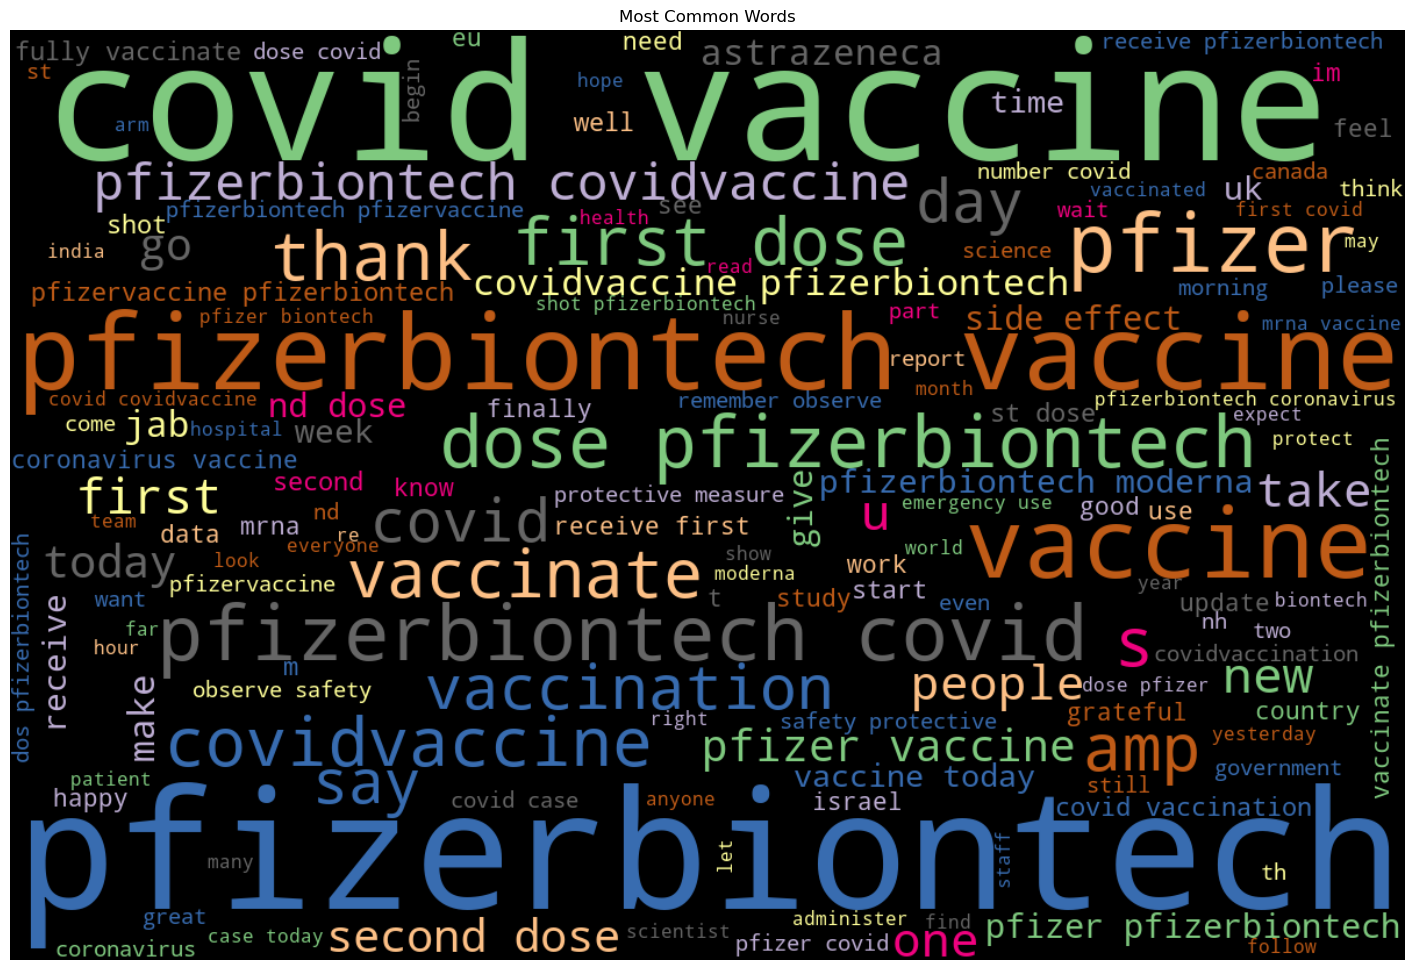

In [46]:

Word_CL = WordCloud(background_color = "black",contour_width = 0.1,contour_color = 'grey',
                    colormap = 'Accent',mode="RGB",max_words=150,max_font_size=150,
                    width = 1200, height = 800).generate(cont)
plt.figure(figsize=(18,18))
plt.imshow(Word_CL,interpolation="bilinear")
plt.title("Most Common Words")
plt.axis("off")
plt.show()
